In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
np.random.seed(13)

In [3]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [4]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [5]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [6]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

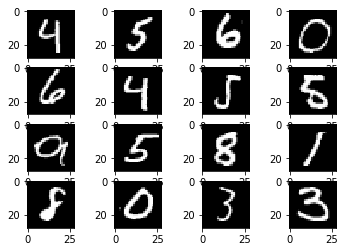

In [7]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [8]:
# Подготовка датасета
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/(std + 0.00001)
import sklearn.model_selection
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.2)
y_train_oh = np.array(list(map(lambda x : encoder.transform(x), y_train)))
y_valid_oh = np.array(list(map(lambda x : encoder.transform(x), y_valid)))

In [9]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.matmul(dz, self.W) 
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        return self.dx

In [10]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        self.x = x
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [11]:
def softmax_func(x):
    x = x - np.amax(x)
    return np.exp(x) / np.sum(np.exp(x))
    
class Softmax:
    def forward(self, x):
        self.x = x
        self.softmax = softmax_func(x)
        return self.softmax
    
    def backward(self, dz, lr = 0.001):
        ds = - np.outer(self.softmax, self.softmax) + np.diag(self.softmax)
        return np.dot(ds, dz)

In [12]:
class Max:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [13]:
class CrossEntropy:
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat) )
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true/self.y_hat

In [14]:
def compute_loss(X, Y_true, net, loss):
    n = X.shape[0]
    L_cur = 0
    for i in range(n):
        y_pred = net.forward(X[i])
        L_cur += loss.forward(Y_true[i], y_pred)
    return L_cur / n

In [15]:
# Опеределение самой сети
class MnistNet:
    def __init__(self, in_size, out_size, rlambda):
        self.drop1 = Dropout(0.5)
        self.dense1 = Dense(in_size, 400, rlambda)
        self.max1 = Max()
        self.drop2 = Dropout(0.5)
        self.dense2 = Dense(400, out_size, rlambda)
        self.smax1 = Softmax()
        
    def forward(self, x):
        net = self.drop1.forward(x)
        net = self.dense1.forward(net)
        net = self.max1.forward(net)
        net = self.drop2.forward(net)
        net = self.dense2.forward(net)
        net = self.smax1.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.smax1.backward(dz, lr)
        dz = self.dense2.backward(dz,lr)
        dz = self.drop2.backward(dz, lr)
        dz = self.max1.backward(dz, lr)
        dz = self.dense1.backward(dz, lr)
        dz = self.drop1.backward(dz,lr)
        return dz

In [16]:
# Здесь процедура обучения
net = MnistNet(x_train.shape[1], y_train_oh.shape[1], 0.0005)
net.drop1.set_train(True)
loss = CrossEntropy()
lr = 0.0005
eras = 30
L_train_dropout = [0.] * eras
L_train = [0.] * eras
L_valid = [0.] * eras
Acc_train = [0.] * eras
Acc_train_dropout = [0.] * eras
Acc_valid = [0.] * eras

import datetime
for iter in range(eras):
    t1 = datetime.datetime.now()
    L_train_cur = 0.
    net.drop1.set_train(True)
    net.drop2.set_train(True)
    sh = list(range(x_train.shape[0]))
    np.random.shuffle(sh)
    for i in range(x_train.shape[0]):
        x = x_train[sh[i]]
        y_true = y_train_oh[sh[i]]
        y_pred = net.forward(x)
        L = loss.forward(y_true, y_pred)
        L_train_cur += L
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_train_cur /= y_train_oh.shape[0]
    L_train_dropout[iter] = L_train_cur
    Acc_train_dropout[iter] = compute_acc(x_train, y_train, net)
    net.drop1.set_train(False)
    net.drop2.set_train(False)
    L_train[iter] = compute_loss(x_train, y_train_oh, net, loss)
    Acc_train[iter] = compute_acc(x_train, y_train, net)
    L_valid_cur = 0.
    for i in range(x_valid.shape[0]):
        x = x_valid[i]
        y_true = y_valid_oh[i]
        y_pred = net.forward(x)
        L = loss.forward(y_true, y_pred)
        L_valid_cur += L
    L_valid_cur /= y_valid_oh.shape[0]
    L_valid[iter] = L_valid_cur
    Acc_valid[iter] = compute_acc(x_valid, y_valid, net)
    t2 = datetime.datetime.now()
    print("{} | Time: {} | Acc. train: {} | Acc. test: {}".format(iter, t2 - t1, Acc_train[iter], Acc_valid[iter]))

0 | Time: 0:02:22.137371 | Acc. train: 0.919404761904762 | Acc. test: 0.9165714285714286
1 | Time: 0:02:21.072644 | Acc. train: 0.9305476190476191 | Acc. test: 0.9251428571428572
2 | Time: 0:02:22.412141 | Acc. train: 0.9412142857142857 | Acc. test: 0.9337142857142857
3 | Time: 0:02:20.131350 | Acc. train: 0.9478571428571428 | Acc. test: 0.9400952380952381
4 | Time: 0:02:20.008522 | Acc. train: 0.9523809523809523 | Acc. test: 0.9448571428571428
5 | Time: 0:02:20.224433 | Acc. train: 0.955952380952381 | Acc. test: 0.9486666666666667
6 | Time: 0:02:21.502270 | Acc. train: 0.9588333333333333 | Acc. test: 0.9495238095238095
7 | Time: 0:03:00.291571 | Acc. train: 0.9614047619047619 | Acc. test: 0.9536190476190476
8 | Time: 0:02:23.092915 | Acc. train: 0.9633571428571429 | Acc. test: 0.9542857142857143
9 | Time: 0:02:46.725026 | Acc. train: 0.9667142857142857 | Acc. test: 0.9572380952380952
10 | Time: 0:03:40.237206 | Acc. train: 0.9682857142857143 | Acc. test: 0.9583809523809523
11 | Time: 

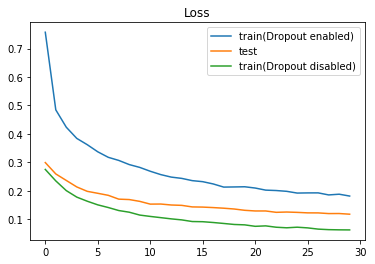

In [17]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.title('Loss')
plt.plot(L_train_dropout, label="train(Dropout enabled)")
plt.plot(L_valid, label="test")
plt.plot(L_train, label="train(Dropout disabled)")
plt.legend()

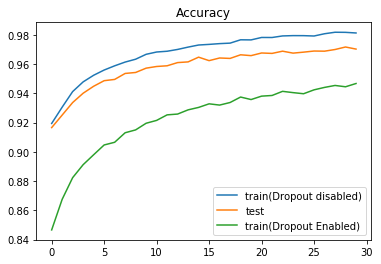

In [18]:
plt.title('Accuracy')
plt.plot(Acc_train, label="train(Dropout disabled)")
plt.plot(Acc_valid, label="test")
plt.plot(Acc_train_dropout, label="train(Dropout Enabled)")
plt.legend()

In [19]:
X_test_norm = (X_test - mean)/(std + 0.00001)

In [20]:
# формируем сабмишшен и заливаем его на kaggle
net.drop1.set_train(False)
net.drop2.set_train(False)
make_submission(X_test_norm, net)